In [1]:
import json
import pandas as pd
import numpy as np
import os

from sklearn.metrics import ndcg_score

from pathlib import Path
from shutil import copyfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

# Functions

In [3]:
def get_single_source_scores_dict(path):
    # Dictionary mapping each table to its combined score from single source 
    single_source_scores_dict = {}

    for query_id in sorted(os.listdir(path)):
        
        with open(path + query_id + '/search_output/filenameToScore.json') as f:
            scores = json.load(f)['scores']

        for table_dict in scores:
            tableID = table_dict['tableID']
            score = table_dict['score']
            if tableID in single_source_scores_dict:
                single_source_scores_dict[tableID] += score
            else:
                single_source_scores_dict[tableID] = score
    
    return single_source_scores_dict

def get_multi_source_scores_dict(path):
    multi_source_scores_dict = {}
    with open(path + 'search_output/filenameToScore.json') as f:
        scores = json.load(f)['scores']

    for table_dict in scores:
        tableID = table_dict['tableID']
        score = table_dict['score']
        multi_source_scores_dict[tableID] = score

    return multi_source_scores_dict

def get_scores_df(single_source_scores_dict, multi_source_scores_dict):
    scores_dict = {'tableID': list(multi_source_scores_dict.keys()), 'multi_score': list(multi_source_scores_dict.values()), 'single_score': []}

    for tableID in scores_dict['tableID']:
        if tableID in single_source_scores_dict:
            scores_dict['single_score'].append(single_source_scores_dict[tableID])
        else:
            scores_dict['single_score'].append(0)

    scores_df = pd.DataFrame.from_dict(scores_dict)
    scores_df['multi_rank'] = scores_df['multi_score'].rank(ascending=False).values
    scores_df['single_rank'] = scores_df['single_score'].rank(ascending=False).values
    scores_df['rank_delta'] = abs(scores_df['multi_rank'] - scores_df['single_rank'])
    
    return scores_df

def get_ndcg_score(scores_df, measure='score'):
    if measure == 'score':
        gt_scores = [scores_df['multi_score'].values]
        pred_scores = [scores_df['single_score'].values]
    elif measure == 'rank':
        gt_scores = [scores_df['multi_rank'].values]
        pred_scores = [scores_df['single_rank'].values]

    return ndcg_score(gt_scores, pred_scores)

def get_eval_dict(dir):
    ndcg_using_score = []
    ndcg_using_rank = []

    for seed in sorted(os.listdir(dir)):
        single_source_path = dir + seed + '/single_source/'
        multi_source_path = dir + seed + '/multi_source/'

        single_source_scores_dict = get_single_source_scores_dict(single_source_path)
        multi_source_scores_dict = get_multi_source_scores_dict(multi_source_path)

        scores_df = get_scores_df(single_source_scores_dict, multi_source_scores_dict)
        
        # Compute the NDCG using both ranks and scores
        ndcg_using_score.append(get_ndcg_score(scores_df, measure='score'))
        ndcg_using_rank.append(get_ndcg_score(scores_df, measure='rank'))

    eval_dict = {
        'ndcg_score': np.mean(ndcg_using_score), 'std_ndcg_score': np.std(ndcg_using_score), 
        'ndcg_rank': np.mean(ndcg_using_rank), 'std_ndcg_rank': np.std(ndcg_using_rank)
    }
    
    return eval_dict 


# Random Queries (Single-Source vs. Multi-Source)

In [4]:
scores_dirs = ["../../search/ppr_approximation/qsize_5/", "../../search/ppr_approximation/qsize_10/", "../../search/ppr_approximation/qsize_20/"]

eval_dict = {'q_size': [], 'ndcg_score': [], 'std_ndcg_score': [], 'ndcg_rank': [], 'std_ndcg_rank': []}

for dir in scores_dirs:
    q_size = int(Path(dir).parts[-1].split('_')[-1])
    
    tmp_dict = get_eval_dict(dir)

    eval_dict['q_size'].append(q_size)
    eval_dict['ndcg_score'].append(tmp_dict['ndcg_score'])
    eval_dict['std_ndcg_score'].append(tmp_dict['std_ndcg_score'])
    eval_dict['ndcg_rank'].append(tmp_dict['ndcg_rank'])
    eval_dict['std_ndcg_rank'].append(tmp_dict['std_ndcg_rank'])

eval_df = pd.DataFrame.from_dict(eval_dict)
# eval_df['q_size'] = [str(val) for val in eval_df['q_size']]
eval_df

,q_size,ndcg_score,std_ndcg_score,ndcg_rank,std_ndcg_rank
0,5,0.955420,0.034941,0.971479,0.016581
1,10,0.946535,0.039723,0.965107,0.016410
2,20,0.964979,0.042838,0.947023,0.030876


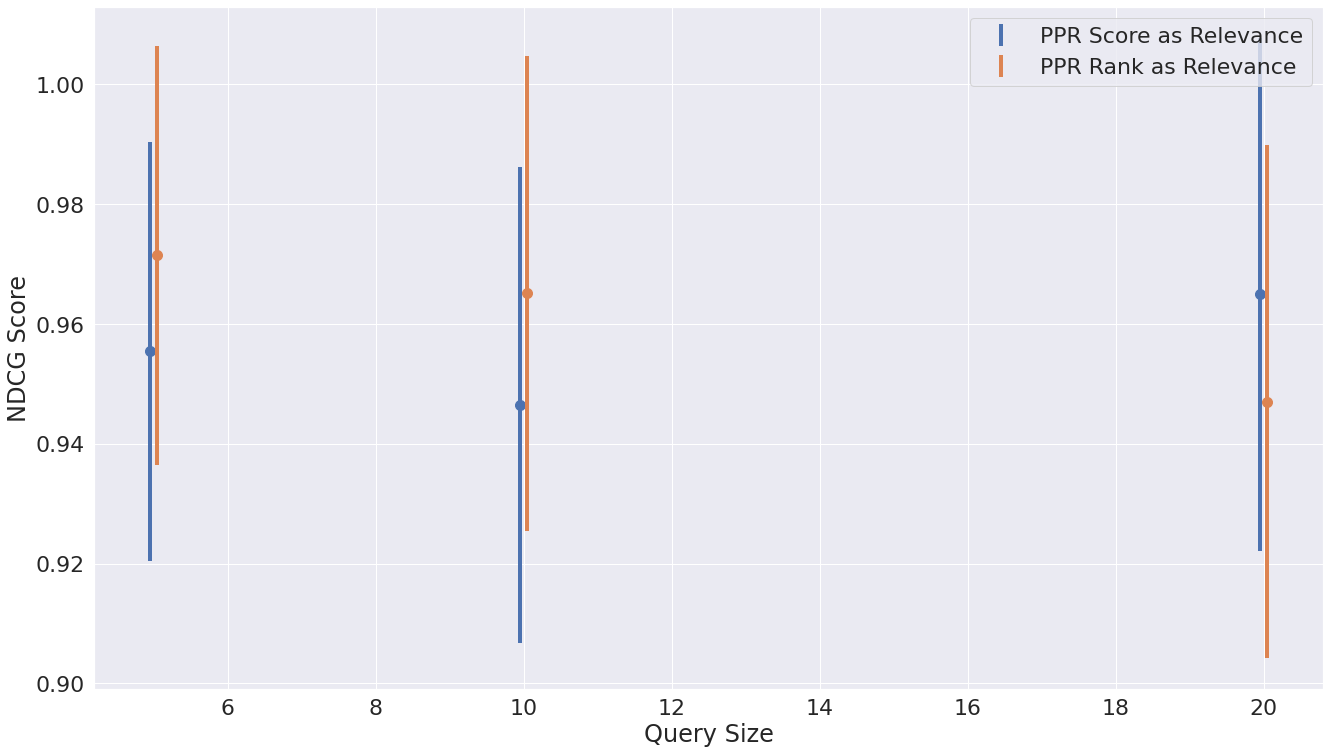

In [5]:
plt.scatter(eval_df['q_size'].to_numpy()-0.05, eval_df['ndcg_score'], s=100)
plt.errorbar(eval_df['q_size'].to_numpy()-0.05, eval_df['ndcg_score'], yerr=eval_df['std_ndcg_score'], ls='none', linewidth=4, label='PPR Score as Relevance')

plt.errorbar(eval_df['q_size'].to_numpy()+0.05, eval_df['ndcg_rank'], yerr=eval_df['std_ndcg_score'], ls='none', linewidth=4, label='PPR Rank as Relevance')
plt.scatter(eval_df['q_size'].to_numpy()+0.05, eval_df['ndcg_rank'], s=100)

plt.xlabel('Query Size');plt.ylabel('NDCG Score');plt.legend();plt.tight_layout()
plt.savefig('figures/ppr_approx_synthetic_queries_qsize.svg')

# Real Queries (Single-Source vs. Multi-Source)

## Generate the Queries

In [6]:
queries_dir='../www18_wikitables/queries/'
output_dir='queries/www18_queries/'

queries_to_choose = [8, 9, 10, 15, 17, 18, 19, 20]

for query_id in queries_to_choose:
    multi_source_dir = output_dir+'query_'+str(query_id)+'/multi_source_query/'
    single_source_dir = output_dir+'query_'+str(query_id)+'/single_source_queries/'
    Path(single_source_dir).mkdir(parents=True, exist_ok=True)
    Path(multi_source_dir).mkdir(parents=True, exist_ok=True)

    # Copy the query to the multi_source_dir 
    original_query_path = queries_dir + 'q_' + str(query_id) + '.json'
    copyfile(original_query_path, multi_source_dir + 'query.json')

    # Generate the appropriate set of single_source queries
    with open(queries_dir + 'q_' + str(query_id) + '.json') as f:
        query_ents = json.load(f)['queries']
    query_ents = list(set(np.array(query_ents).flatten()))
    
    for i in range(len(query_ents)):
        single_source_dict = {'queries': []}
        single_source_dict['queries'].append([query_ents[i]])
        with open(single_source_dir + 'q_' + str(i) + '.json', 'w') as fp:
            json.dump(single_source_dict, fp, indent=4)   

## Evaluate the Queries

In [10]:
def get_eval_df(dir):
    eval_dict = {'query_id': [], 'ndcg_score': [], 'ndcg_rank': [], 'num_tables': []}

    for query in sorted(os.listdir(dir)):
        query_id = int(query.split('_')[1])

        single_source_path = dir + query + '/single_source/'
        multi_source_path = dir + query + '/multi_source/'

        single_source_scores_dict = get_single_source_scores_dict(single_source_path)
        multi_source_scores_dict = get_multi_source_scores_dict(multi_source_path)

        scores_df = get_scores_df(single_source_scores_dict, multi_source_scores_dict)
        
        # Compute the NDCG using both ranks and scores
        ndcgScore = get_ndcg_score(scores_df, measure='score')
        ndcgRank = get_ndcg_score(scores_df, measure='rank')

        eval_dict['query_id'].append(query_id)
        eval_dict['ndcg_score'].append(ndcgScore)
        eval_dict['ndcg_rank'].append(ndcgRank)
        eval_dict['num_tables'].append(len(multi_source_scores_dict.keys()))

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.sort_values(by=['query_id'])
    eval_df['query_id'] = [str(val) for val in eval_df['query_id']]
    
    return eval_df

### Using 200 Particles PPR

In [18]:
dir = "../../search/ppr_approximation/www18_queries/"
eval_df = get_eval_df(dir)
eval_df

,query_id,ndcg_score,ndcg_rank,num_tables
6,8,0.940031,0.894533,72
7,9,0.905000,0.870341,43
0,10,0.982195,0.830655,56
1,15,0.983843,0.945843,78
2,17,0.917810,0.930784,31
3,18,0.977828,0.964785,84
4,19,0.959324,0.933596,39
5,20,0.976529,0.980655,74


In [19]:
eval_df_melt = pd.melt(eval_df, id_vars=['query_id'], value_vars=['ndcg_score', 'ndcg_rank'], value_name='NDCG Score', var_name='Ranking')
replacer_dict = {"ndcg_score": 'PPR score as relevance', "ndcg_rank": 'PPR rank as relevance'}
eval_df_melt = eval_df_melt.replace({"Ranking": replacer_dict})
eval_df_melt

,query_id,Ranking,NDCG Score
0,8,PPR score as relevance,0.940031
1,9,PPR score as relevance,0.905000
2,10,PPR score as relevance,0.982195
3,15,PPR score as relevance,0.983843
4,17,PPR score as relevance,0.917810
5,18,PPR score as relevance,0.977828
6,19,PPR score as relevance,0.959324
7,20,PPR score as relevance,0.976529
8,8,PPR rank as relevance,0.894533
9,9,PPR rank as relevance,0.870341


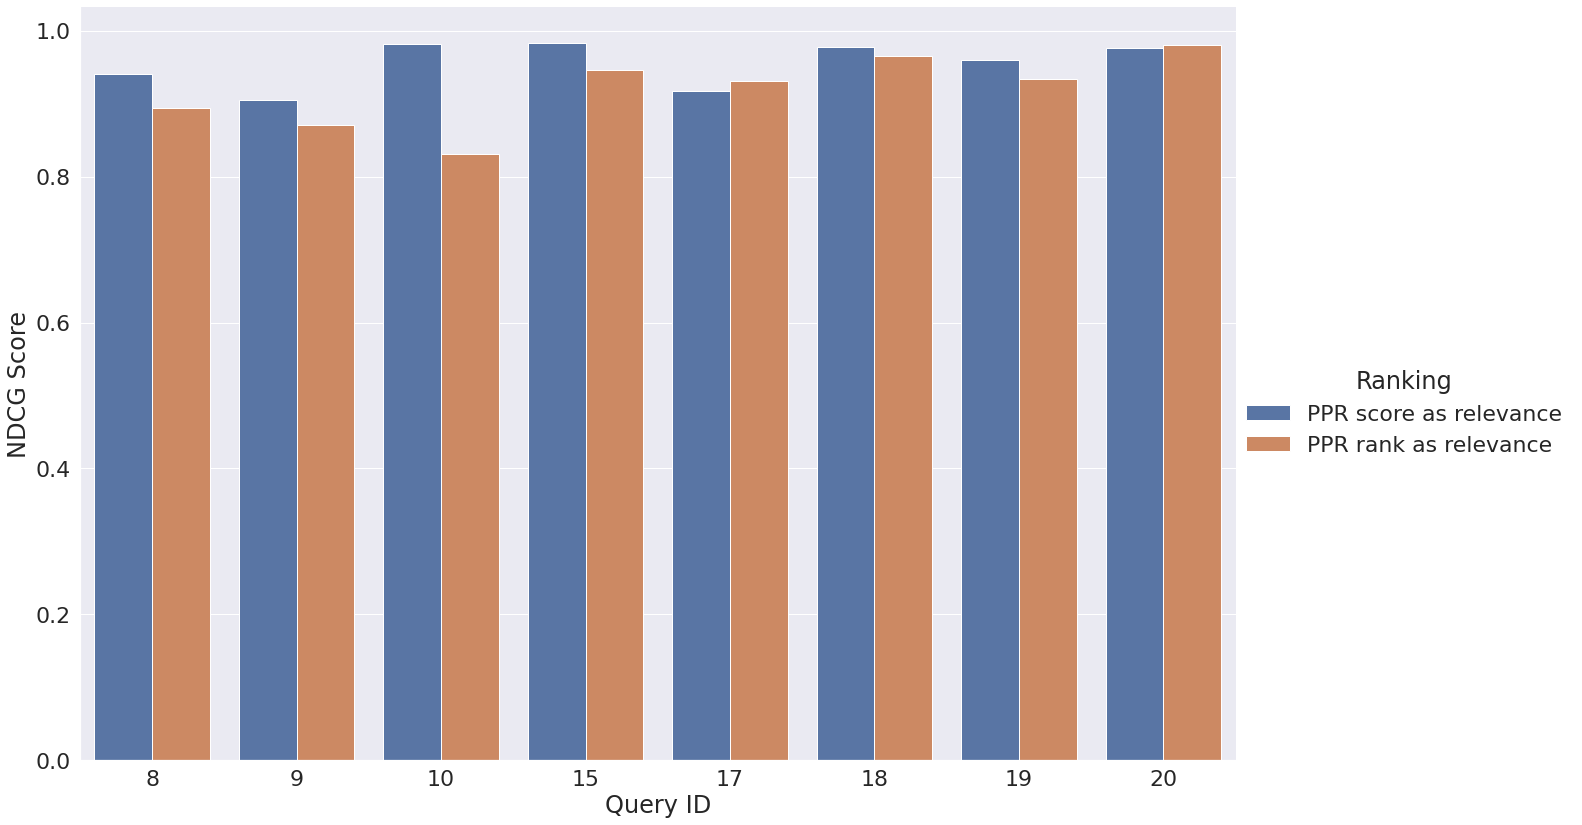

In [20]:
sns.set(font_scale=2)
ax = sns.catplot(x="query_id", y="NDCG Score", kind="bar", hue='Ranking', data=eval_df_melt, height=12, aspect=1.5)
plt.xlabel('Query ID');plt.ylabel("NDCG Score")
plt.savefig('figures/real_queries_ppr_approximation.svg')

### Using 1K Particles PPR

In [21]:
dir = "../../search/ppr_approximation/www18_queries_1k_particles/"
eval_df_1k_particles = get_eval_df(dir)
eval_df_1k_particles

,query_id,ndcg_score,ndcg_rank,num_tables
6,8,0.958886,0.935359,415
7,9,0.929273,0.980397,77
0,10,0.997361,0.996055,182
1,15,0.988284,0.972710,459
2,17,0.936400,0.978204,109
3,18,0.984718,0.983021,341
4,19,0.871847,0.991765,65
5,20,0.967493,0.956918,308


In [32]:
comparison_dict_ppr_as_score = {'Query ID': [], 'Number of Particles': [], 'NDCG Score': []}
comparison_dict_rank_as_score = {'Query ID': [], 'Number of Particles': [], 'NDCG Score': []}

for idx, row in eval_df.iterrows():
    comparison_dict_ppr_as_score['Query ID'].append(row['query_id'])
    comparison_dict_ppr_as_score['Number of Particles'].append(200)
    comparison_dict_ppr_as_score['NDCG Score'].append(row['ndcg_score'])

    comparison_dict_rank_as_score['Query ID'].append(row['query_id'])
    comparison_dict_rank_as_score['Number of Particles'].append(200)
    comparison_dict_rank_as_score['NDCG Score'].append(row['ndcg_rank'])

for idx, row in eval_df_1k_particles.iterrows():
    comparison_dict_ppr_as_score['Query ID'].append(row['query_id'])
    comparison_dict_ppr_as_score['Number of Particles'].append(1000)
    comparison_dict_ppr_as_score['NDCG Score'].append(row['ndcg_score'])

    comparison_dict_rank_as_score['Query ID'].append(row['query_id'])
    comparison_dict_rank_as_score['Number of Particles'].append(1000)
    comparison_dict_rank_as_score['NDCG Score'].append(row['ndcg_rank'])


comparison_df_ppr_as_score = pd.DataFrame.from_dict(comparison_dict_ppr_as_score)
comparison_df_rank_as_score = pd.DataFrame.from_dict(comparison_dict_rank_as_score)

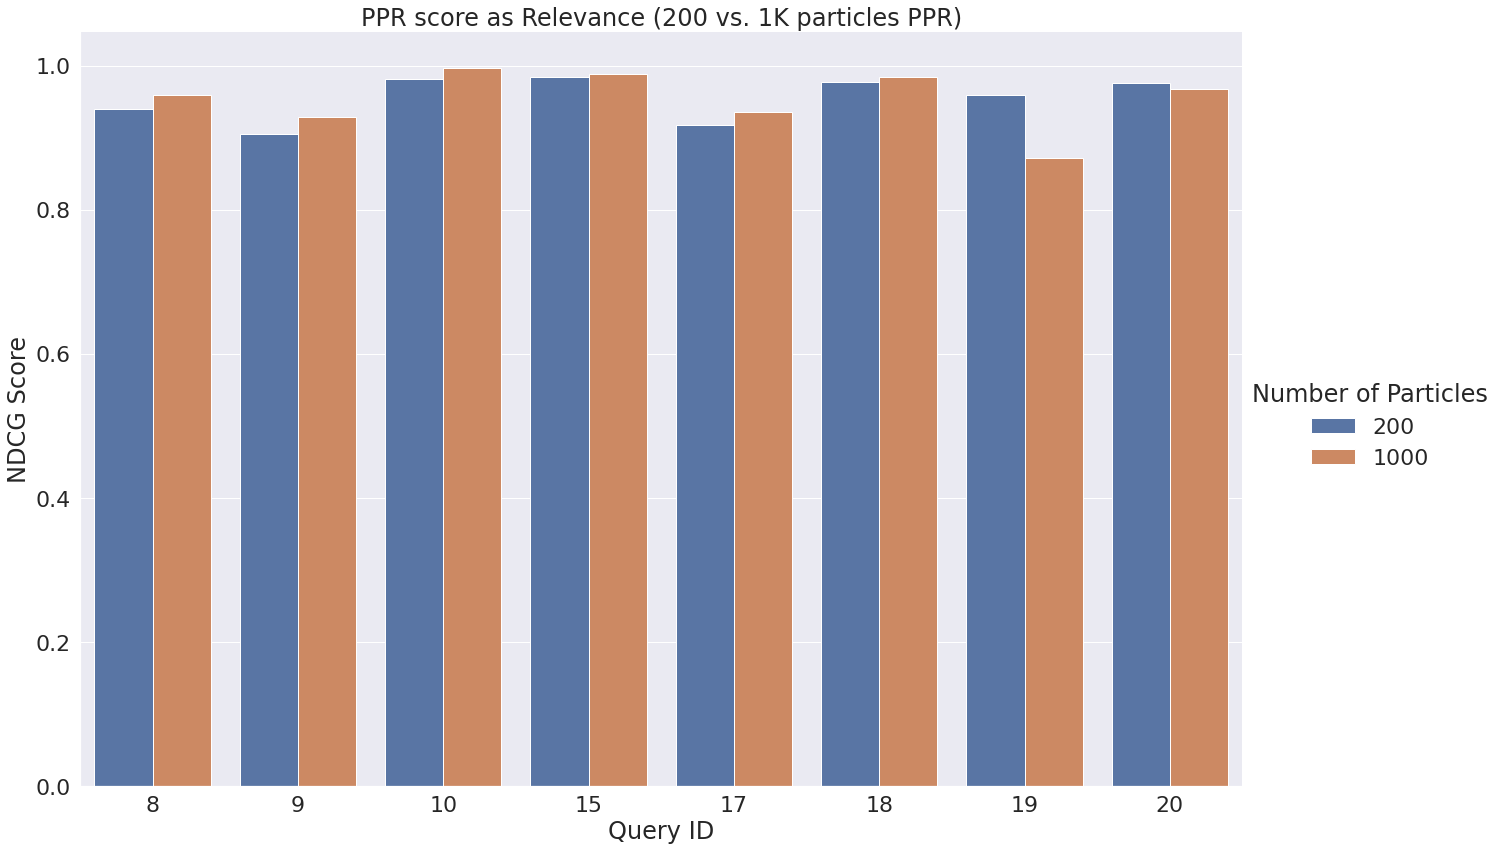

In [35]:
ax = sns.catplot(x="Query ID", y="NDCG Score", kind="bar", hue='Number of Particles', data=comparison_df_ppr_as_score, height=12, aspect=1.5)
plt.title('PPR score as Relevance (200 vs. 1K particles PPR)')
plt.savefig('figures/200_vs_1k_particles_ppr_as_score.svg')

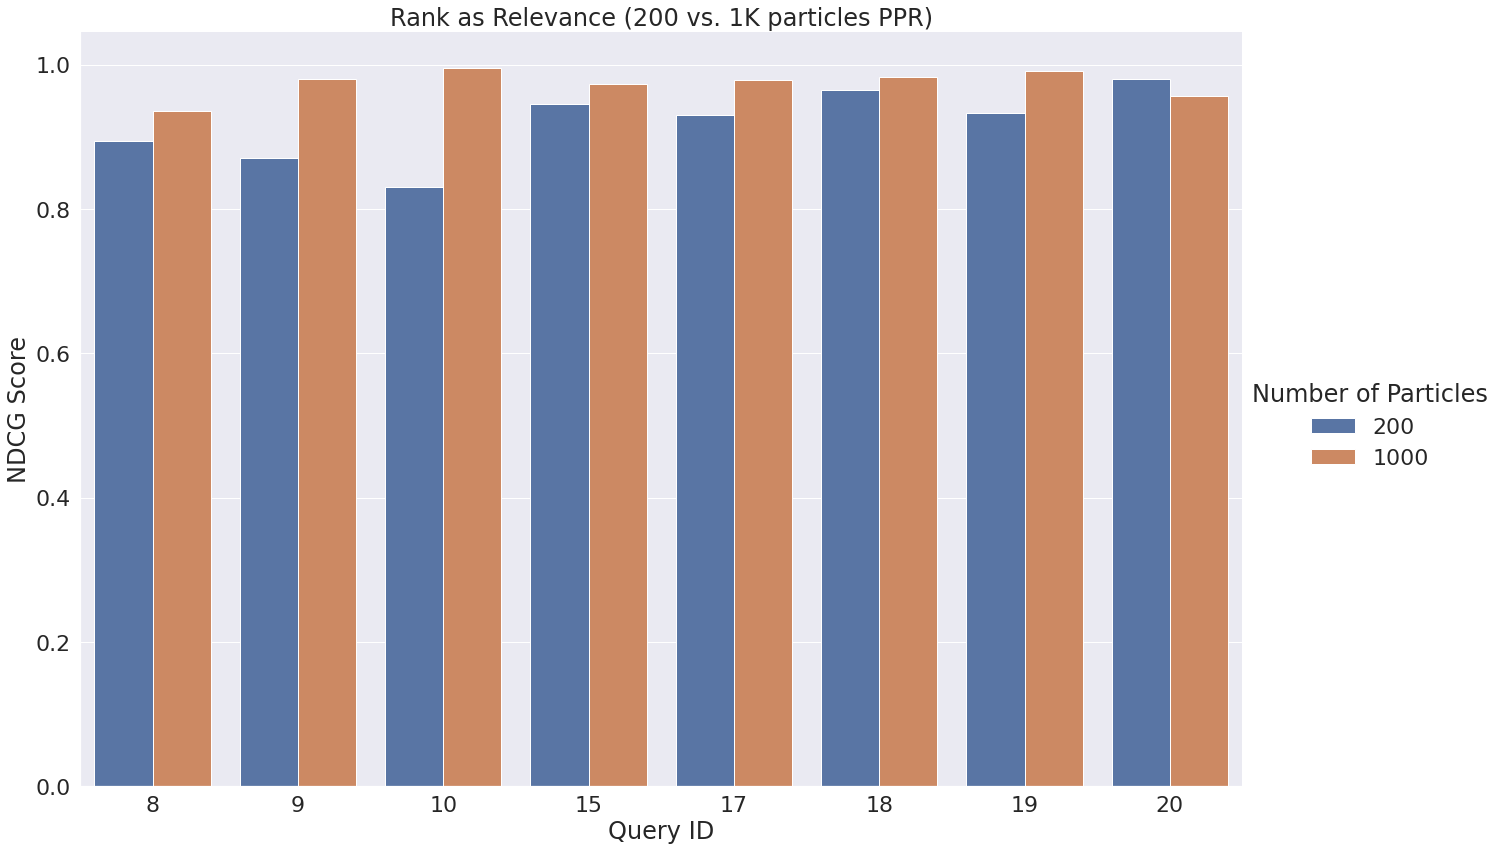

In [37]:
ax = sns.catplot(x="Query ID", y="NDCG Score", kind="bar", hue='Number of Particles', data=comparison_df_rank_as_score, height=12, aspect=1.5)
plt.title('Rank as Relevance (200 vs. 1K particles PPR)')
plt.savefig('figures/200_vs_1k_particles_rank_as_score.svg')

# Testing

In [2]:
# Combine single source PPR scores

single_source_scores_dir = "../../search/ppr_approximation/single_source/"

# Dictionary mapping each table to its combined score from single source 
single_source_scores_dict = {}

for query_id in sorted(os.listdir(single_source_scores_dir)):
    
    with open(single_source_scores_dir + query_id + '/search_output/filenameToScore.json') as f:
        scores = json.load(f)['scores']

    for table_dict in scores:
        tableID = table_dict['tableID']
        score = table_dict['score']
        if tableID in single_source_scores_dict:
            single_source_scores_dict[tableID] += score
        else:
            single_source_scores_dict[tableID] = score

In [3]:
multi_source_scores_path = "../../search/ppr_approximation/multi_source/q_4/"

multi_source_scores_dict = {}
with open(multi_source_scores_path + 'search_output/filenameToScore.json') as f:
    scores = json.load(f)['scores']

for table_dict in scores:
    tableID = table_dict['tableID']
    score = table_dict['score']
    multi_source_scores_dict[tableID] = score

multi_source_scores_dict

{'table-0575-167.json': 10.167990293410233,
 'table-0315-968.json': 7.876548161698888,
 'table-0120-171.json': 4.258069411246791,
 'table-0808-557.json': 2.1587992437449546,
 'table-0351-772.json': 0.9879319510962504,
 'table-0404-981.json': 0.951212404129716,
 'table-1560-840.json': 0.7855888058171779,
 'table-1282-345.json': 0.6908009506352283,
 'table-1321-698.json': 0.5884439433960149,
 'table-1587-722.json': 0.49592307498100757,
 'table-0939-371.json': 0.4685765443788762,
 'table-0591-321.json': 0.4504351796653986,
 'table-0495-148.json': 0.34927553385731297,
 'table-1082-949.json': 0.14390445892166664,
 'table-0210-885.json': 0.13440942183008847,
 'table-0671-318.json': 0.12237325518770081,
 'table-1495-178.json': 0.12149539403157907,
 'table-1317-968.json': 0.09994760047994547,
 'table-1082-947.json': 0.09089013377211759,
 'table-1082-951.json': 0.08398280031414446,
 'table-1471-461.json': 0.0818736667661199,
 'table-0647-805.json': 0.06893899804548506,
 'table-0913-280.json': 0

In [7]:
scores_dict = {'tableID': list(multi_source_scores_dict.keys()), 'multi_score': list(multi_source_scores_dict.values()), 'single_score': []}

for tableID in scores_dict['tableID']:
    if tableID in single_source_scores_dict:
        scores_dict['single_score'].append(single_source_scores_dict[tableID])
    else:
        scores_dict['single_score'].append(0)

scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df['multi_rank'] = scores_df['multi_score'].rank(ascending=False).values
scores_df['single_rank'] = scores_df['single_score'].rank(ascending=False).values
scores_df['rank_delta'] = abs(scores_df['multi_rank'] - scores_df['single_rank'])
scores_df


,tableID,multi_score,single_score,multi_rank,single_rank,rank_delta
0,table-0575-167.json,10.167990,41.759161,1.0,1.0,0.0
1,table-0315-968.json,7.876548,30.059248,2.0,2.0,0.0
2,table-0120-171.json,4.258069,27.219528,3.0,3.0,0.0
3,table-0808-557.json,2.158799,7.301042,4.0,4.0,0.0
4,table-0351-772.json,0.987932,4.156112,5.0,6.0,1.0
5,table-0404-981.json,0.951212,6.043156,6.0,5.0,1.0
6,table-1560-840.json,0.785589,1.767365,7.0,13.0,6.0
7,table-1282-345.json,0.690801,4.002338,8.0,7.0,1.0
8,table-1321-698.json,0.588444,3.440949,9.0,8.0,1.0
9,table-1587-722.json,0.495923,3.136363,10.0,10.0,0.0


In [8]:
gt_scores = [scores_df['single_rank'].values]
pred_scores = [scores_df['multi_rank'].values]
print("NDCG using ranks:", ndcg_score(gt_scores, pred_scores))

NDCG using ranks: 0.9824627973933732


In [9]:
gt_scores = [scores_df['multi_score'].values]
pred_scores = [scores_df['single_score'].values]
print("NDCG using scores:", ndcg_score(gt_scores, pred_scores))

NDCG using scores: 0.9990291628972809
